In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
import pyccl as ccl
import yaml

In [2]:
s = sacc.Sacc().load_fits("../data/DESY1_cls/cls_covG_new.fits")

In [3]:
with open('../data/DESY1_cls/order.yml') as f:
    config = yaml.safe_load(f)

In [4]:
def get_type(name):
    if 'wl' in name:
        return 'e'
    else:
        return '0'

In [5]:
indices = []
for cl in config['order']:
    t1, t2 = cl['tracers']
    lmin, lmax = cl['ell_cuts']
    cl_name = 'cl_%s%s' % (get_type(t1), get_type(t2))
    ind = s.indices(cl_name, (t1, t2),
                    ell__gt=lmin, ell__lt=lmax)
    indices += list(ind)
s.keep_indices(indices)

In [6]:
cls = []
ls = []
indices = []
pairs = []
for cl in config['order']:
    t1, t2 = cl['tracers']
    lmin, lmax = cl['ell_cuts']
    cl_name = 'cl_%s%s' % (get_type(t1), get_type(t2))
    l, c_ell, ind = s.get_ell_cl(cl_name, t1, t2, return_cov=False, return_ind=True)
    indices += list(ind)
    cls += list(c_ell)
    ls.append(l)
    pairs.append([t1, t2])
indices = np.array(indices)
cls = np.array(cls)
cov = s.covariance.dense[indices][:, indices]
w, v = np.linalg.eigh(cov)
cov = np.dot(v, np.dot(np.diag(np.fabs(w)), v.T))
cov = np.tril(cov) + np.triu(cov.T, 1)

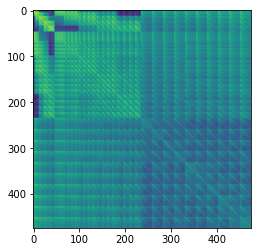

In [7]:
plt.imshow(np.log((cov**2)**0.5))
plt.show()

In [8]:
tracer_code = {'DESgc': 1, 'DESwl': 2}
tracers = []
for n, t in s.tracers.items():
    if n.startswith('DES'):
        tracer = tracer_code[n[:5]]
        binn = int(n[-1])
        tracers.append([tracer, binn])

In [9]:
pairs_id = []
pairs_coded = []
for pair, l in zip(pairs, ls):
    t1, t2 = pair
    typ1 = tracer_code[t1[:5]] 
    bin1 = int(t1[-1])
    typ2 = tracer_code[t2[:5]]
    bin2 = int(t2[-1])
    id1 = tracers.index([typ1, bin1])
    id2 = tracers.index([typ2, bin2])
    ids = [id1+1, id2+1]
    pair = [typ1, bin1, typ2, bin2]
    pairs_id.append(ids)
    pairs_coded.append(pair)

In [10]:
dict_save = {'tracers': tracers, 'pairs': pairs_coded, 'pairs_ids': pairs_id, 'cls': cls, 'cov': cov}

In [11]:
for n, t in s.tracers.items():
    if n.startswith('DES'):
        tracer = tracer_code[n[:5]]
        binn = n[-1]
        dict_save[f'nz_{tracer}{binn}'] = np.array([t.z, t.nz])

In [12]:
for pair, l in zip(pairs, ls):
    t1, t2 = pair
    bin1 = int(t1[-1])
    t1 = tracer_code[t1[:5]]
    t1 = int(f'{t1}{bin1}')
    bin2 = int(t2[-1])
    t2 = tracer_code[t2[:5]]
    t2 = int(f'{t2}{bin2}')
    dict_save[f'ls_{t1}{t2}'] = l

In [13]:
np.savez("Cls_meta.npz", **dict_save)

In [14]:
d = np.load("Cls_meta.npz")

In [15]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [16]:
is_pos_def(d['cov'])

True